In [1]:
import os
import random
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score,
                           confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Dense, Dropout, LSTM,
                                   Embedding, Bidirectional,
                                   BatchNormalization, SpatialDropout1D)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from google.colab import files


# Initialize NLP tools
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# 1. Data Loading and Preprocessing
with open('/content/dataset.json', 'r') as file:
    intents = json.load(file)

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((pattern, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))


Data Loading & Preprocessing:
Loads intents from JSON file (patterns & responses)
Tokenizes and lemmatizes text, removes punctuation
Builds vocabulary (words) and intent classes (tags)
Saves processed data as pickle files for model training

In [3]:
# 2. Feature Engineering
vectorizer = TfidfVectorizer(
    max_features=3000,
    stop_words='english',
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True
)

X = vectorizer.fit_transform([doc[0] for doc in documents]).toarray()
y = np.array([classes.index(doc[1]) for doc in documents])

# Handle class imbalance with adjusted SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_onehot = tf.keras.utils.to_categorical(y_resampled, num_classes=len(classes))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
sample_weights = np.array([class_weights[i] for i in y_resampled])

# Train-test split with stratification
trainX, testX, trainY, testY = train_test_split(
    X_resampled, y_onehot, test_size=0.2, random_state=42, stratify=y_resampled)

# Sequence data for LSTM with enhanced preprocessing
tokenizer = Tokenizer(oov_token="<OOV>", num_words=5000)
tokenizer.fit_on_texts([doc[0] for doc in documents])
vocab_size = len(tokenizer.word_index) + 1

X_texts = [doc[0] for doc in documents]
X_seq = tokenizer.texts_to_sequences(X_texts)
max_len = max([len(x) for x in X_seq])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Apply SMOTE to LSTM data
X_resampled_lstm, y_resampled_lstm = smote.fit_resample(X_pad, y)
y_onehot_lstm = tf.keras.utils.to_categorical(y_resampled_lstm, num_classes=len(classes))

# Train-test split for LSTM with stratification
trainX_lstm, testX_lstm, trainY_lstm, testY_lstm = train_test_split(
    X_resampled_lstm, y_onehot_lstm, test_size=0.2, random_state=42, stratify=y_resampled_lstm)


Feature Engineering & Data Preparation:
Converts text to TF-IDF vectors (1-3 ngrams, 3000 features)
Handles class imbalance using SMOTE oversampling
Generates class weights for balanced training
Creates sequential data for LSTM (tokenization + padding)
Splits data into train/test sets (stratified 80/20 split)

In [4]:
# 3. Visualization Functions
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    filtered_features = [
        (feature, importance)
        for feature, importance in zip(feature_names, importances)
        if len(feature) > 2 and not any(char.isdigit() for char in feature)
    ]
    top_features = sorted(filtered_features, key=lambda x: x[1], reverse=True)[:15]

    plt.figure(figsize=(10, 6))
    plt.barh(
        [feature for feature, _ in top_features],
        [importance for _, importance in top_features],
        color='dodgerblue'
    )
    plt.title(f'Top 15 {model_name} Features')
    plt.xlabel('Importance Score')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_model_metrics(y_true, y_pred, model_name):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1': f1_score(y_true, y_pred, average='weighted')
    }

    plt.figure(figsize=(8, 4))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange', 'red'])
    plt.title(f'{model_name} Performance Metrics')
    plt.ylim(0, 1.1)
    plt.ylabel('Score')
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.05, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', pad=20)
    plt.xlabel('Predicted', labelpad=15)
    plt.ylabel('Actual', labelpad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()

def plot_learning_curve_xgb(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    plt.title('XGBoost Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.show()


Visualization Utilities:
plot_training_history(): Tracks model accuracy/loss across epochs
plot_feature_importance(): Shows top 15 influential text features
plot_model_metrics(): Compares accuracy/precision/recall/F1 scores
plot_confusion_matrix(): Visualizes classification errors per intent
plot_learning_curve_xgb(): Displays XGBoost's training progress

In [7]:
# 4. Model Definitions
def create_nn(input_dim):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(len(classes), activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_lstm(vocab_size, max_len):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_len, mask_zero=True),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)),
        Dropout(0.4),
        Bidirectional(LSTM(32, recurrent_dropout=0.2)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(len(classes), activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Model Architectures:
create_nn(): Builds a dense neural network with:
-3 hidden layers (512-256-128 nodes)
-L2 regularization & dropout for robustness
-Batch normalization for stable training
create_improved_lstm(): Creates a bidirectional LSTM model with:
-Word embeddings + spatial dropout
-Two LSTM layers (64-32 units)
-Recurrent dropout to prevent overfitting

In [8]:
# 5. Enhanced Training Functions
def train_and_evaluate_nn():
    print("\nTraining Improved Neural Network...")
    model = create_nn(trainX.shape[1])

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=0.001
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )

    history = model.fit(
        trainX, trainY,
        epochs=150,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    plot_training_history(history, "Neural Network")

    y_pred = np.argmax(model.predict(testX), axis=1)
    y_true = np.argmax(testY, axis=1)

    present_classes = np.unique(np.concatenate([y_true, y_pred]))
    present_class_names = [classes[i] for i in present_classes]

    plot_confusion_matrix(y_true, y_pred, present_class_names, "Neural Network")
    plot_model_metrics(y_true, y_pred, "Neural Network")

    print("\nClassification Report for Neural Network:")
    print(classification_report(y_true, y_pred,
                              labels=present_classes,
                              target_names=present_class_names,
                              zero_division=0))

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1': f1_score(y_true, y_pred, average='weighted')
    }

def train_and_evaluate_lstm():
    print("\nTraining Improved LSTM Model...")
    model = create_lstm(vocab_size, max_len)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.001
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    history = model.fit(
        trainX_lstm, trainY_lstm,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    plot_training_history(history, "LSTM")

    y_pred = np.argmax(model.predict(testX_lstm), axis=1)
    y_true = np.argmax(testY_lstm, axis=1)

    present_classes = np.unique(np.concatenate([y_true, y_pred]))
    present_class_names = [classes[i] for i in present_classes]

    plot_confusion_matrix(y_true, y_pred, present_class_names, "LSTM")
    plot_model_metrics(y_true, y_pred, "LSTM")

    print("\nClassification Report for LSTM:")
    print(classification_report(y_true, y_pred,
                              labels=present_classes,
                              target_names=present_class_names,
                              zero_division=0))

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1': f1_score(y_true, y_pred, average='weighted')
    }

def train_and_evaluate_xgboost():
    print("\nTraining Optimized XGBoost Model...")
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=2,
        reg_lambda=2,
        scale_pos_weight=2,
        eval_metric='mlogloss',
        early_stopping_rounds=30,
        random_state=42
    )

    eval_set = [(trainX, np.argmax(trainY, axis=1)),
                (testX, np.argmax(testY, axis=1))]

    model.fit(
        trainX,
        np.argmax(trainY, axis=1),
        sample_weight=sample_weights[:len(trainX)],
        eval_set=eval_set,
        verbose=1
    )

    plot_learning_curve_xgb(model)

    y_pred = model.predict(testX)
    y_true = np.argmax(testY, axis=1)

    present_classes = np.unique(np.concatenate([y_true, y_pred]))
    present_class_names = [classes[i] for i in present_classes]

    plot_confusion_matrix(y_true, y_pred, present_class_names, "XGBoost")
    feature_names = vectorizer.get_feature_names_out()
    plot_feature_importance(model, feature_names, "XGBoost")
    plot_model_metrics(y_true, y_pred, "XGBoost")

    print("\nClassification Report for XGBoost:")
    print(classification_report(y_true, y_pred,
                              labels=present_classes,
                              target_names=present_class_names,
                              zero_division=0))

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1': f1_score(y_true, y_pred, average='weighted')
    }

def train_and_evaluate_rf():
    print("\nTraining Optimized Random Forest...")
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=3,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    )

    model.fit(trainX, np.argmax(trainY, axis=1))

    y_pred = model.predict(testX)
    y_true = np.argmax(testY, axis=1)

    present_classes = np.unique(np.concatenate([y_true, y_pred]))
    present_class_names = [classes[i] for i in present_classes]

    plot_confusion_matrix(y_true, y_pred, present_class_names, "Random Forest")
    feature_names = vectorizer.get_feature_names_out()
    plot_feature_importance(model, feature_names, "Random Forest")
    plot_model_metrics(y_true, y_pred, "Random Forest")

    print("\nClassification Report for Random Forest:")
    print(classification_report(y_true, y_pred,
                              labels=present_classes,
                              target_names=present_class_names,
                              zero_division=0))

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1': f1_score(y_true, y_pred, average='weighted')
    }


Model Training & Evaluation Functions:
Neural Network Training:
-Uses early stopping and learning rate reduction
-Trains for 150 epochs with 64 batch size
-Generates accuracy/loss plots and confusion matrix
-Returns weighted performance metrics
LSTM Training:
-Implements bidirectional LSTM with dropout
-200 epochs with 32 batch size
-Includes extended patience for early stopping
-Visualizes sequence model performance
XGBoost Training:
-Optimized with custom hyperparameters
-Tracks learning curve via mlogloss
-Shows feature importance for interpretation
-Handles class imbalance via sample weights
Random Forest Training:
-500 estimators with balanced class weights
-Uses sqrt(max_features) for diversity
-Displays top predictive features
-Generates full classification report


Training Improved Neural Network...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.0728 - loss: 6.6285 - val_accuracy: 0.2946 - val_loss: 6.0815 - learning_rate: 0.0010
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4443 - loss: 4.9731 - val_accuracy: 0.5089 - val_loss: 5.9478 - learning_rate: 0.0010
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6930 - loss: 3.9896 - val_accuracy: 0.5000 - val_loss: 5.8195 - learning_rate: 0.0010
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7958 - loss: 3.5087 - val_accuracy: 0.5089 - val_loss: 5.6987 - learning_rate: 0.0010
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8499 - loss: 3.1591 - val_accuracy: 0.4643 - val_loss: 5.5870 - learning_rate: 0.0010
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8679 - loss: 2.9237 - val_accuracy: 0.3929 - val_loss: 5.4829 - learning_rate: 0.0010
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8579 - loss: 2.8022 - val_accuracy: 

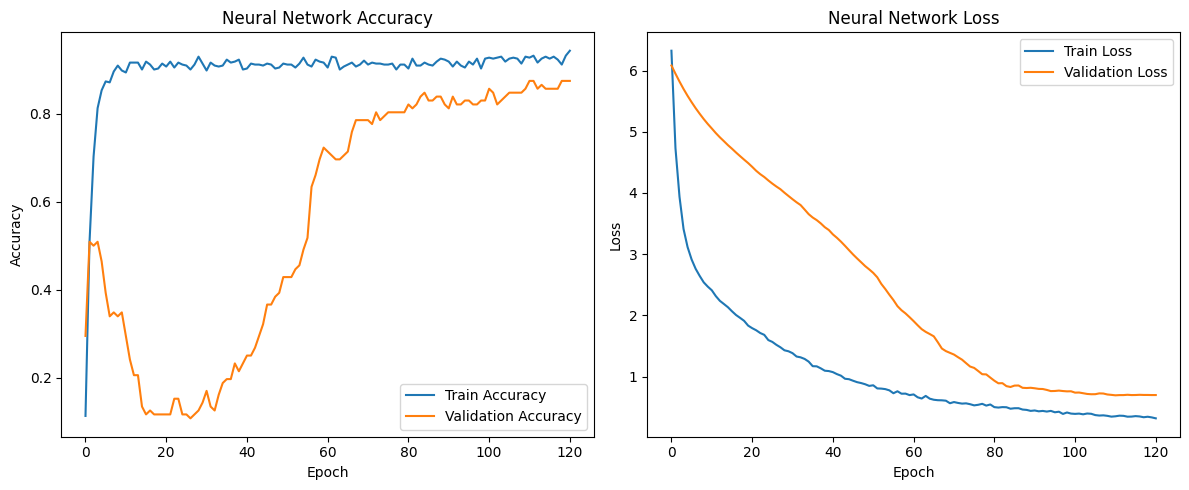

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


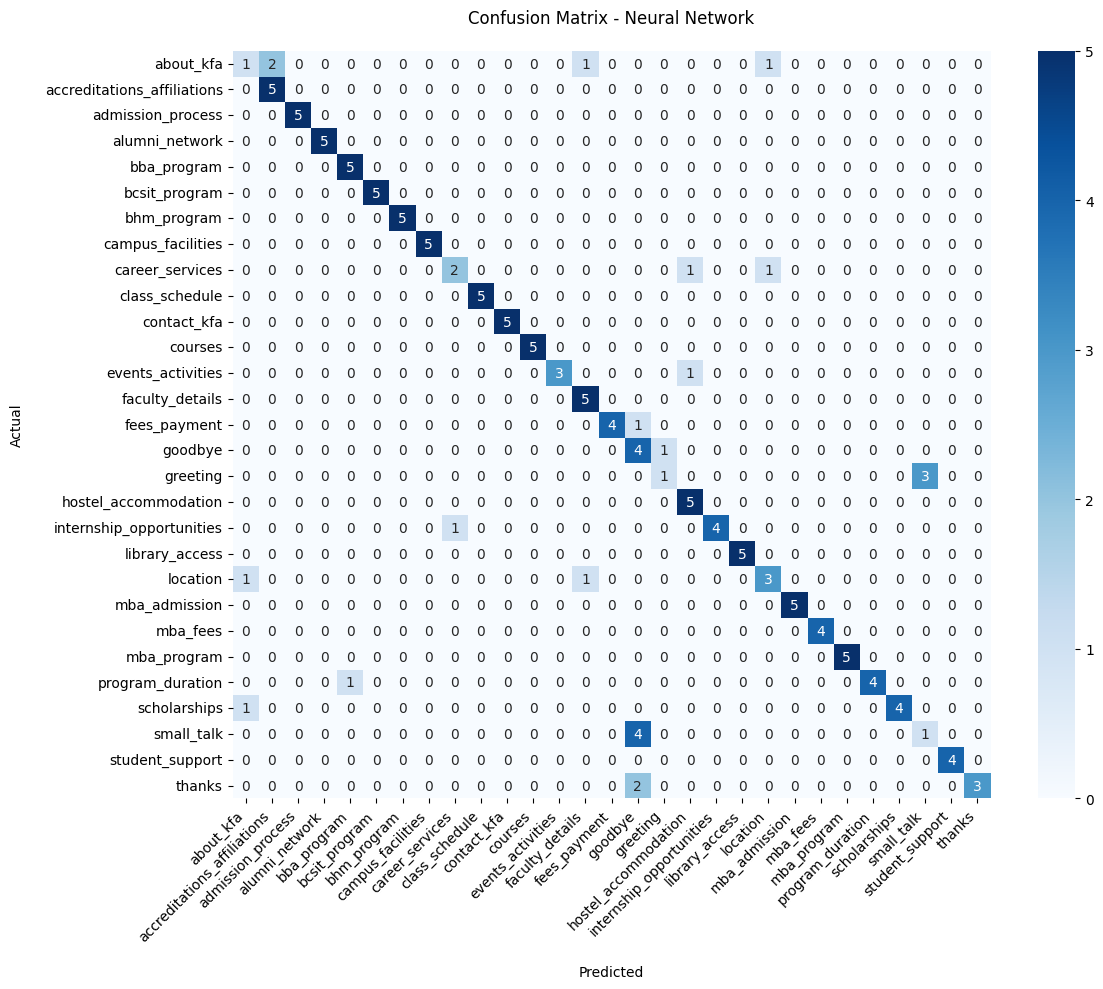

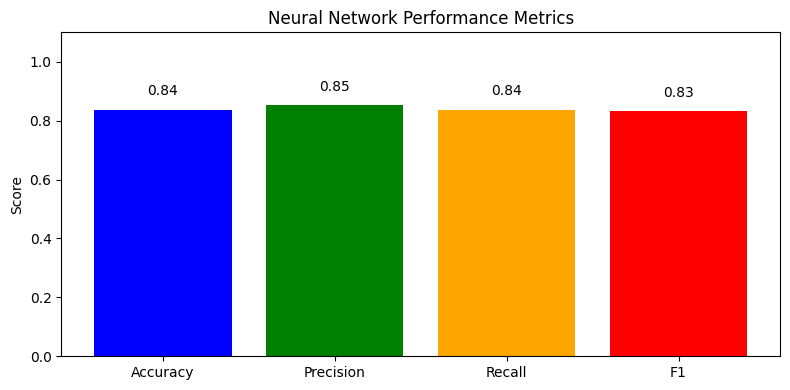


Classification Report for Neural Network:
                             precision    recall  f1-score   support

                  about_kfa       0.33      0.20      0.25         5
accreditations_affiliations       0.71      1.00      0.83         5
          admission_process       1.00      1.00      1.00         5
             alumni_network       1.00      1.00      1.00         5
                bba_program       0.83      1.00      0.91         5
              bcsit_program       1.00      1.00      1.00         5
                bhm_program       1.00      1.00      1.00         5
          campus_facilities       1.00      1.00      1.00         5
            career_services       0.67      0.50      0.57         4
             class_schedule       1.00      1.00      1.00         5
                contact_kfa       1.00      1.00      1.00         5
                    courses       1.00      1.00      1.00         5
          events_activities       1.00      0.75      0.86 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - accuracy: 0.0487 - loss: 3.3670 - val_accuracy: 0.0357 - val_loss: 3.3675 - learning_rate: 5.0000e-04
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.0643 - loss: 3.3641 - val_accuracy: 0.0179 - val_loss: 3.3684 - learning_rate: 5.0000e-04
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.0662 - loss: 3.3608 - val_accuracy: 0.0000e+00 - val_loss: 3.3700 - learning_rate: 5.0000e-04
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.0720 - loss: 3.3531 - val_accuracy: 0.0089 - val_loss: 3.3728 - learning_rate: 5.0000e-04
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.0483 - loss: 3.3491 - val_accuracy: 0.0179 - val_loss: 3.3738 - learning_rate: 5.0000e-04
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.0504 - loss: 3.3310 - val_accuracy: 0.0179 - val_loss: 3.3801 - learning_rate: 5.0000e-04
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.044

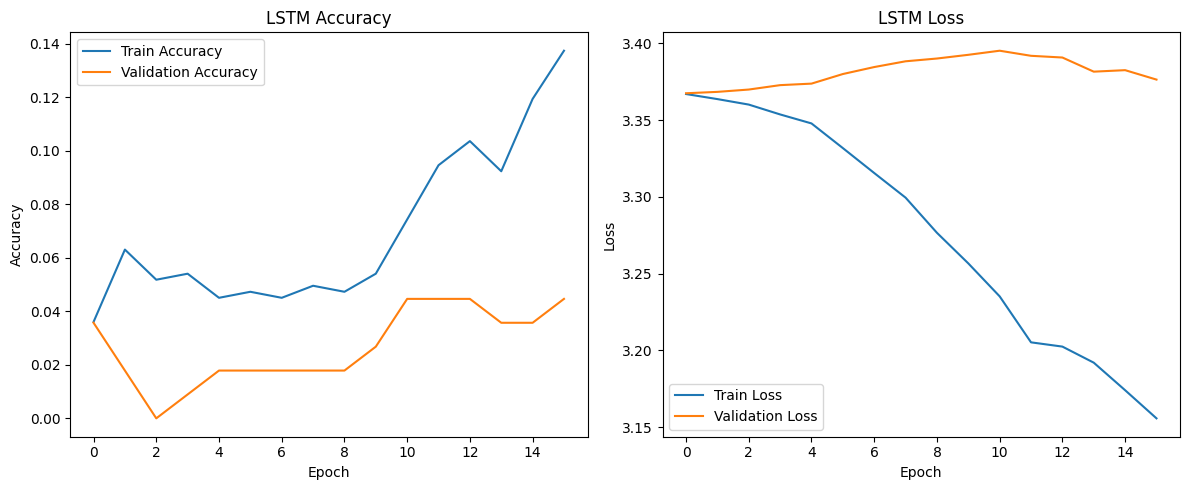

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step


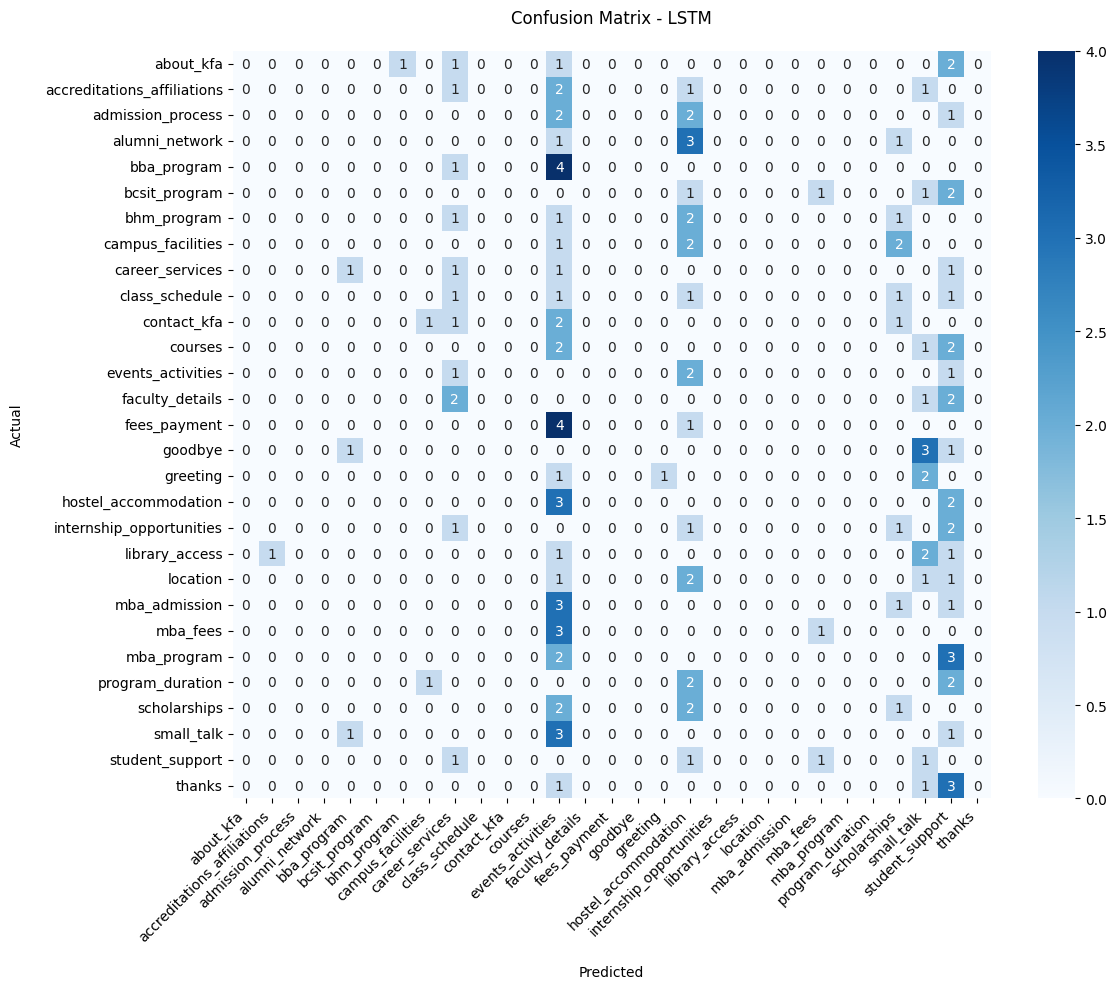

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


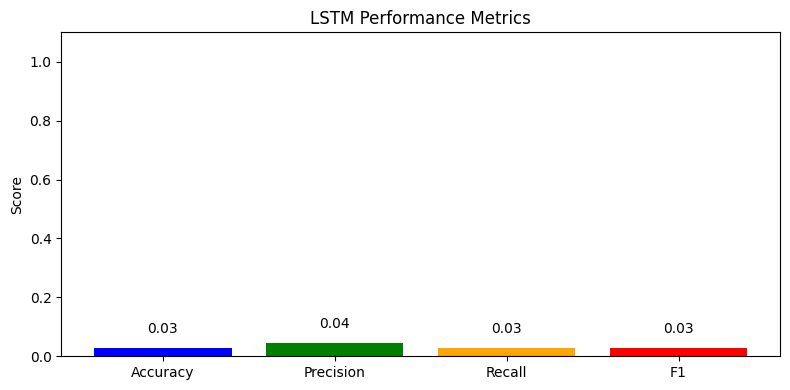

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for LSTM:
                             precision    recall  f1-score   support

                  about_kfa       0.00      0.00      0.00         5
accreditations_affiliations       0.00      0.00      0.00         5
          admission_process       0.00      0.00      0.00         5
             alumni_network       0.00      0.00      0.00         5
                bba_program       0.00      0.00      0.00         5
              bcsit_program       0.00      0.00      0.00         5
                bhm_program       0.00      0.00      0.00         5
          campus_facilities       0.00      0.00      0.00         5
            career_services       0.08      0.25      0.12         4
             class_schedule       0.00      0.00      0.00         5
                contact_kfa       0.00      0.00      0.00         5
                    courses       0.00      0.00      0.00         5
          events_activities       0.00      0.00      0.00         4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-mlogloss:3.32091	validation_1-mlogloss:3.32696
[5]	validation_0-mlogloss:3.31089	validation_1-mlogloss:3.31797
[6]	validation_0-mlogloss:3.30167	validation_1-mlogloss:3.31003
[7]	validation_0-mlogloss:3.29217	validation_1-mlogloss:3.30148
[8]	validation_0-mlogloss:3.28489	validation_1-mlogloss:3.29503
[9]	validation_0-mlogloss:3.27400	validation_1-mlogloss:3.28671
[10]	validation_0-mlogloss:3.26609	validation_1-mlogloss:3.28133
[11]	validation_0-mlogloss:3.25429	validation_1-mlogloss:3.27218
[12]	validation_0-mlogloss:3.24671	validation_1-mlogloss:3.26598
[13]	validation_0-mlogloss:3.23719	validation_1-mlogloss:3.25822
[14]	validation_0-mlogloss:3.22802	validation_1-mlogloss:3.25100
[15]	validation_0-mlogloss:3.22068	validation_1-mlogloss:3.24454
[16]	validation_0-mlogloss:3.21108	validation_1-mlogloss:3.23679
[17]	validation_0-mlogloss:3.20265	validation_1-mlogloss:3.22990
[18]	validation_0-mlogloss:3.19125	validation_1-mlogloss:3.22095
[19]	validation_0-mlogloss:3.18

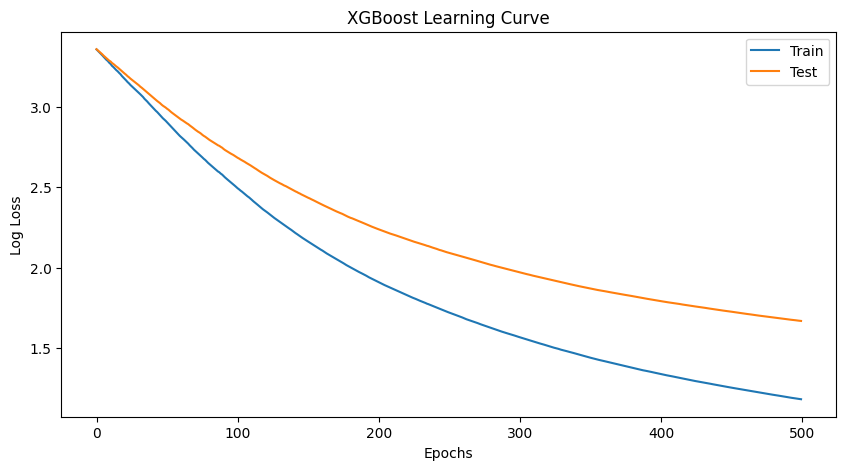

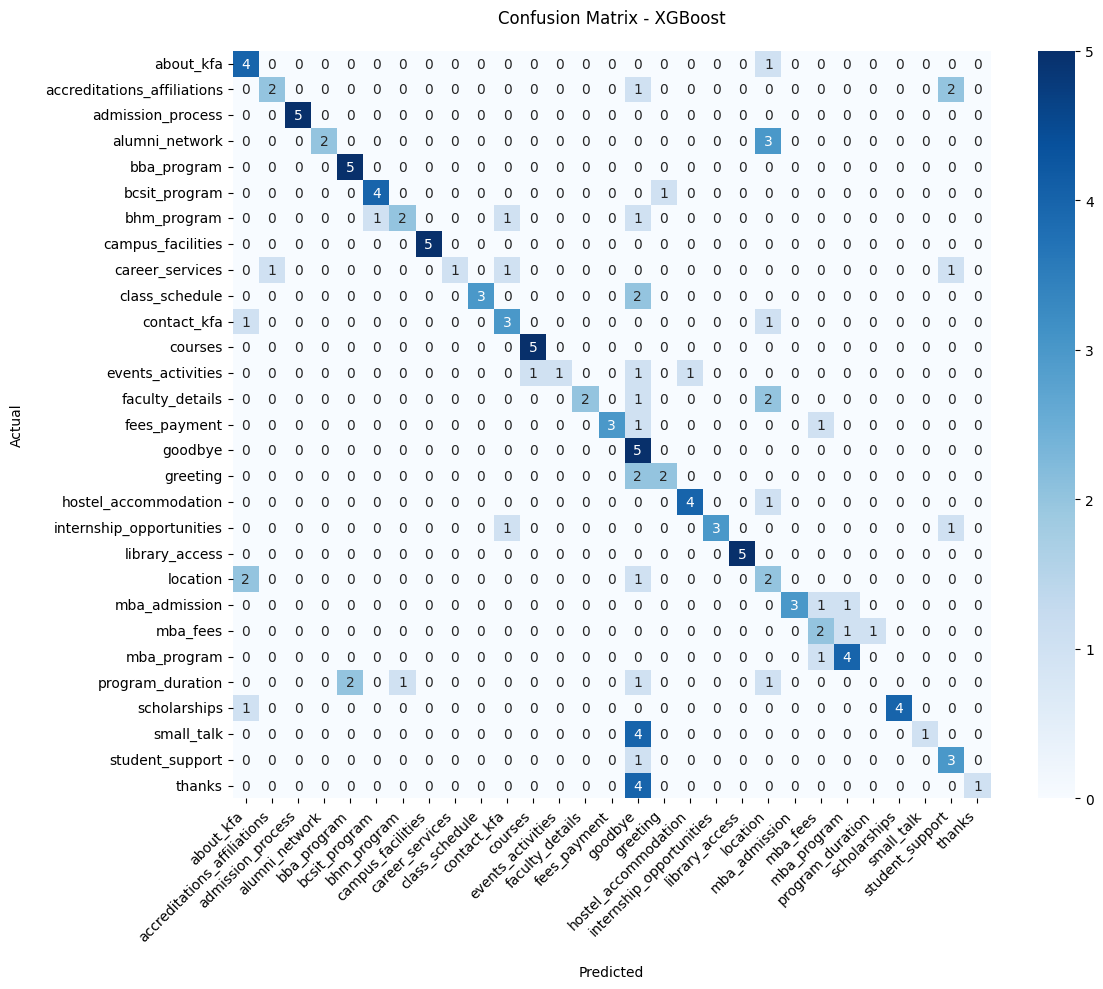

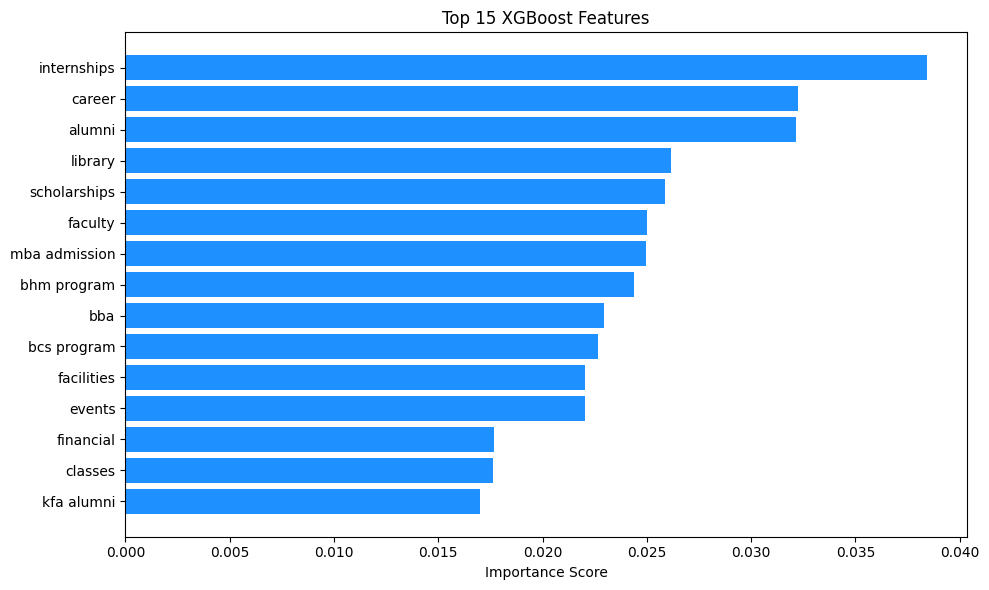

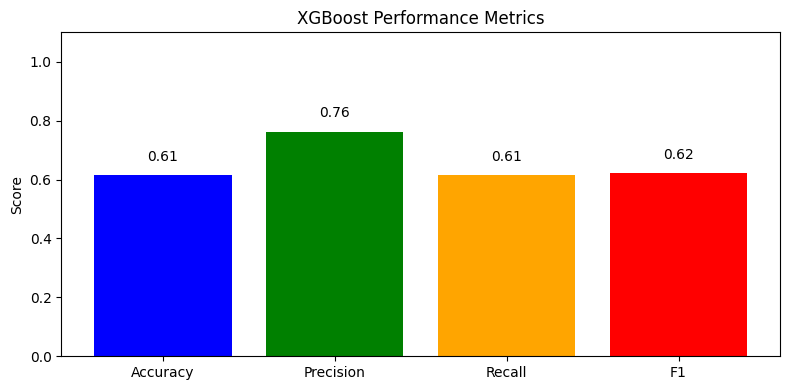


Classification Report for XGBoost:
                             precision    recall  f1-score   support

                  about_kfa       0.50      0.80      0.62         5
accreditations_affiliations       0.67      0.40      0.50         5
          admission_process       1.00      1.00      1.00         5
             alumni_network       1.00      0.40      0.57         5
                bba_program       0.71      1.00      0.83         5
              bcsit_program       0.80      0.80      0.80         5
                bhm_program       0.67      0.40      0.50         5
          campus_facilities       1.00      1.00      1.00         5
            career_services       1.00      0.25      0.40         4
             class_schedule       1.00      0.60      0.75         5
                contact_kfa       0.50      0.60      0.55         5
                    courses       0.83      1.00      0.91         5
          events_activities       1.00      0.25      0.40        

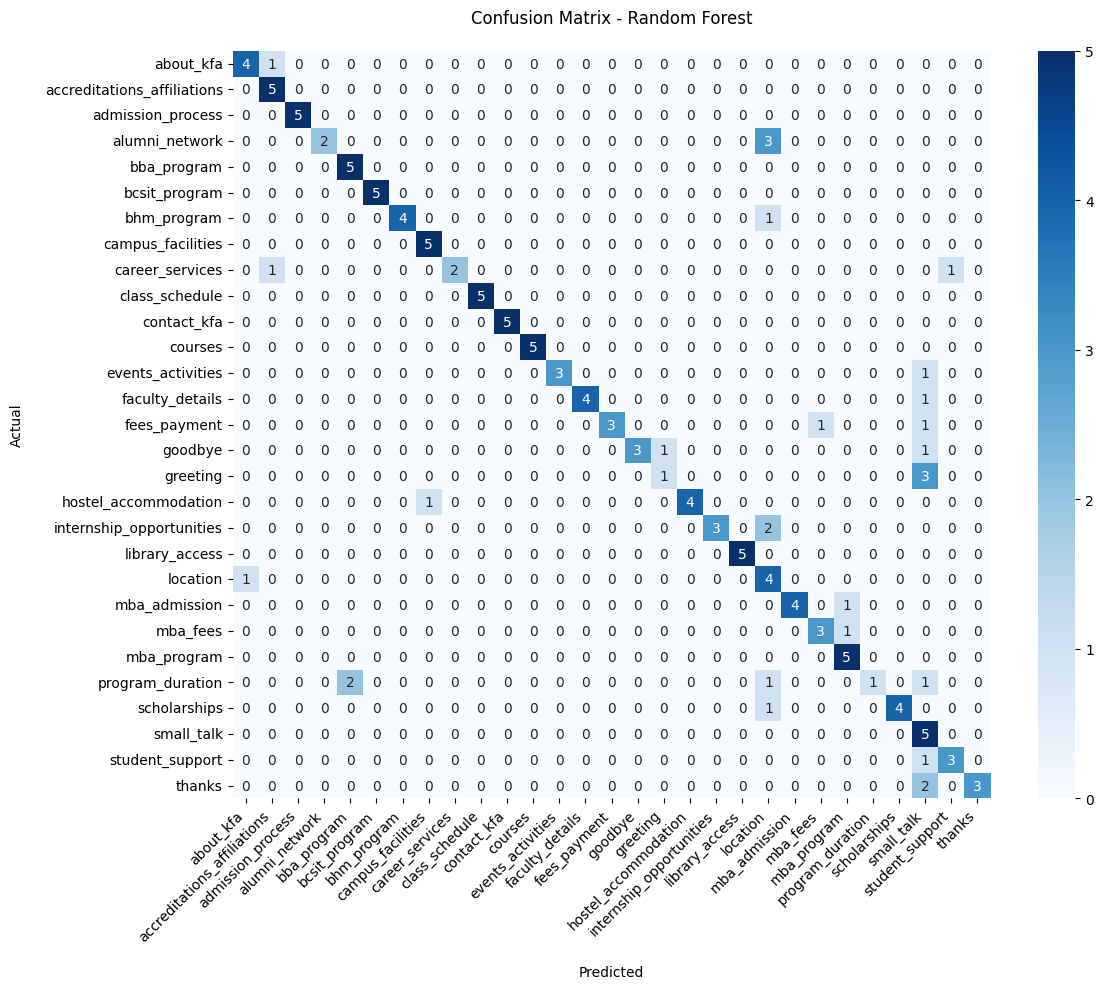

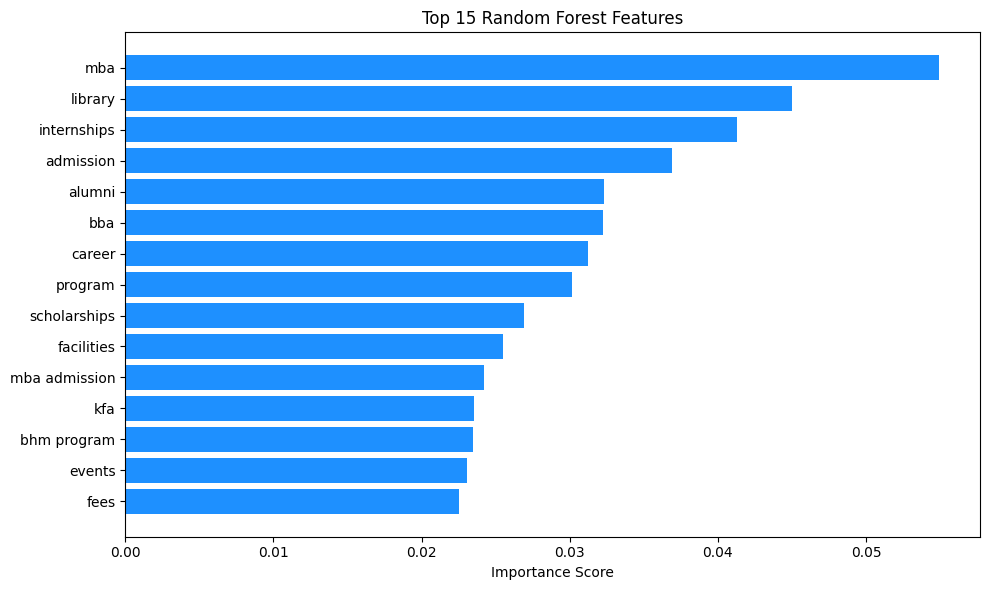

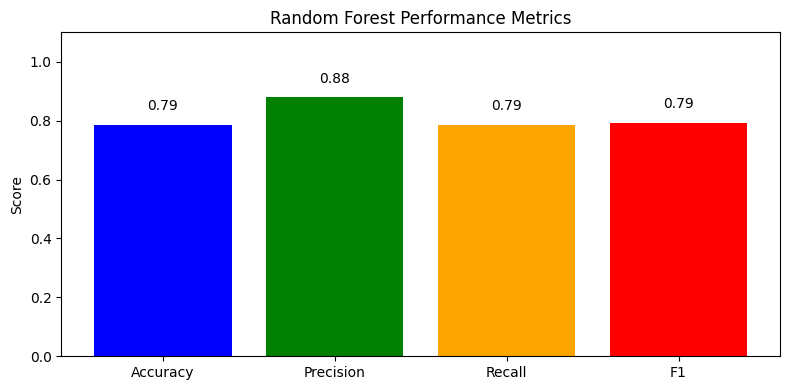


Classification Report for Random Forest:
                             precision    recall  f1-score   support

                  about_kfa       0.80      0.80      0.80         5
accreditations_affiliations       0.71      1.00      0.83         5
          admission_process       1.00      1.00      1.00         5
             alumni_network       1.00      0.40      0.57         5
                bba_program       0.71      1.00      0.83         5
              bcsit_program       1.00      1.00      1.00         5
                bhm_program       1.00      0.80      0.89         5
          campus_facilities       0.83      1.00      0.91         5
            career_services       1.00      0.50      0.67         4
             class_schedule       1.00      1.00      1.00         5
                contact_kfa       1.00      1.00      1.00         5
                    courses       1.00      1.00      1.00         5
          events_activities       1.00      0.75      0.86  

<Figure size 1000x600 with 0 Axes>

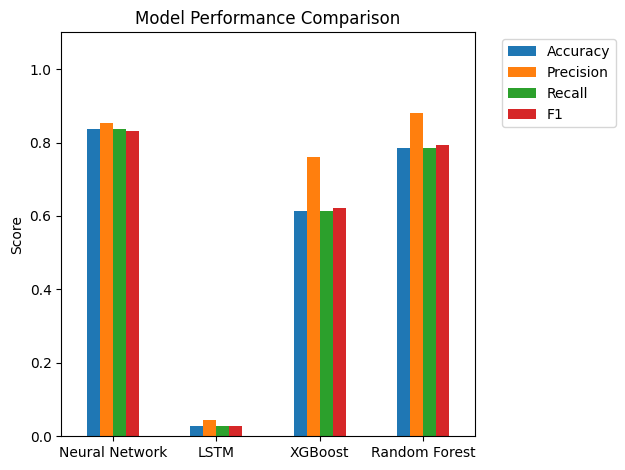


Best Model: Neural Network
Saved TF-IDF vectorizer as 'tfidf_vectorizer.pkl'
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1026 - loss: 6.4483
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5779 - loss: 4.2907
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8083 - loss: 3.4338
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8588 - loss: 3.0578
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8753 - loss: 2.8076
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8776 - loss: 2.6789
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8904 - loss: 2.5340
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9111 - loss: 2.3612
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8939 - loss: 2.2964
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9180 - loss: 2.1662
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9009 - loss: 2.1363
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8997 - l

In [9]:
# 6. Main Execution
if __name__ == "__main__":
    # Train all models
    results = {
        'Neural Network': train_and_evaluate_nn(),
        'LSTM': train_and_evaluate_lstm(),
        'XGBoost': train_and_evaluate_xgboost(),
        'Random Forest': train_and_evaluate_rf()
    }

    # Compare results
    results_df = pd.DataFrame.from_dict(results, orient='index')
    print("\nModel Performance Comparison:")
    print(results_df.sort_values('Accuracy', ascending=False))

    plt.figure(figsize=(10, 6))
    results_df.plot(kind='bar', rot=0)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Save best model
    best_model_name = results_df['Accuracy'].idxmax()
    print(f"\nBest Model: {best_model_name}")

    # Save the TF-IDF vectorizer
    pickle.dump(vectorizer, open('tfidf_vectorizer.pkl', 'wb'))
    print("Saved TF-IDF vectorizer as 'tfidf_vectorizer.pkl'")


    if best_model_name == 'Neural Network':
        model = create_nn(trainX.shape[1])
        model.fit(X_resampled, y_onehot, epochs=50, batch_size=64)
        model.save('kfabot.keras')
        print("Saved Keras model as 'kfabot.keras'")
    elif best_model_name == 'LSTM':
        model = create_lstm(vocab_size, max_len)
        model.fit(X_resampled_lstm, y_onehot_lstm, epochs=100, batch_size=32)
        model.save('kfabot_lstm.keras')
        print("Saved LSTM model as 'kfabot_lstm.keras'")
    elif best_model_name == 'XGBoost':
        model = XGBClassifier(
            n_estimators=500,
            learning_rate=0.01,
            max_depth=5,
            random_state=42
        )
        model.fit(X_resampled, np.argmax(y_onehot, axis=1))
        pickle.dump(model, open('kfabot_xgb.pkl', 'wb'))
        print("Saved XGBoost model as 'kfabot_xgb.pkl'")
    else:  # Random Forest
        model = RandomForestClassifier(
            n_estimators=500,
            max_depth=15,
            random_state=42
        )
        model.fit(X_resampled, np.argmax(y_onehot, axis=1))
        pickle.dump(model, open('kfabot_rf.pkl', 'wb'))
        print("Saved Random Forest model as 'kfabot_rf.pkl'")


Main Execution & Model Deployment:
-Trains and compares all models (Neural Network, LSTM, XGBoost, Random Forest)
-Generates performance comparison chart with accuracy metrics
-Automatically selects and saves the best-performing model
-Persists all necessary artifacts (TF-IDF vectorizer + best model)

Key operations:
-Model training and evaluation
-Performance comparison visualization
-Smart model selection (highest accuracy)
-Production-ready model serialization



In [10]:
'''import random
import json
import pickle
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import load_model

# Initialize NLP tools
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
'''
# Enhanced fallback responses
fallback_responses = [
    "I'm not sure about that. Would you like information about our programs?",
    "Could you ask about a specific program like MBA or BBA?",
    "I specialize in KFA Business School information. Could you rephrase?",
    "For that, you might want to contact admissions at +977-1-4591414"
]

def load_chatbot():
    print("Loading chatbot resources...")
    try:
        intents = json.load(open('dataset.json'))
        words = pickle.load(open('words.pkl', 'rb'))
        classes = pickle.load(open('classes.pkl', 'rb'))
        vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))

        # Try loading models with priority order
        try:
            model = load_model('kfabot.keras')
            model_type = 'keras'
        except:
            try:
                model = pickle.load(open('kfabot_xgb.pkl', 'rb'))
                model_type = 'sklearn'
            except:
                model = pickle.load(open('kfabot_rf.pkl', 'rb'))
                model_type = 'sklearn'

        print("Chatbot ready!")
        return intents, words, classes, model, model_type, vectorizer

    except Exception as e:
        print(f"Failed to load resources: {str(e)}")
        exit()

def process_input(sentence):
    sentence = ''.join([c for c in sentence if c.isalpha() or c.isspace()])
    sentence_words = nltk.word_tokenize(sentence)
    return [lemmatizer.lemmatize(word.lower()) for word in sentence_words]

def predict_intent(sentence, model, model_type, classes, vectorizer):
    sentence_processed = " ".join(process_input(sentence))
    features = vectorizer.transform([sentence_processed]).toarray()[0]

    if model_type == 'keras':
        predictions = model.predict(np.array([features]))[0]
    else:
        predictions = model.predict_proba([features])[0]

    max_prob = max(predictions)
    threshold = max(0.25, max_prob * 0.6)

    results = []
    for i, prob in enumerate(predictions):
        if prob >= threshold:
            results.append({"intent": classes[i], "probability": float(prob)})

    return sorted(results, key=lambda x: x['probability'], reverse=True)

def get_bot_response(intents_list, intents_data, context):
    if not intents_list:
        return random.choice(fallback_responses), context, False

    intent_tag = intents_list[0]['intent']

    # Check for goodbye intent
    if intent_tag == 'goodbye':
        return random.choice([
            "Goodbye! Feel free to ask KFABot anytime about KFA Business School.",
            "See you! KFABot is always here if you have more questions.",
            "Take care! Let me know if you need more help later."
        ]), context, True

    for intent in intents_data['intents']:
        if intent['tag'] == intent_tag:
            # Handle context
            if 'context_set' in intent:
                context.update(intent['context_set'])

            response = random.choice(intent['responses'])

            # Add program-specific follow-up
            if intent_tag in ['mba_program', 'bba_program', 'bcsit_program', 'bhm_program']:
                response += "\nWould you like details about admission requirements or fees?"
                context['awaiting_program_followup'] = intent_tag

            return response, context, False

    return random.choice(fallback_responses), context, False

def chat():
    intents, words, classes, model, model_type, vectorizer = load_chatbot()
    context = {}

    print("\nKFA Chatbot: Hi! Ask me about programs, admissions, or anything else.")

    while True:
        try:
            user_input = input("You: ").strip()

            if user_input.lower() == 'quit':
                print("KFA Chatbot: Goodbye!")
                break

            if not user_input:
                print("KFA Chatbot: Please type something!")
                continue

            # Handle follow-up context
            if 'awaiting_program_followup' in context:
                if 'admission' in user_input.lower():
                    intent_tag = context['awaiting_program_followup'] + '_admission'
                    intents_list = [{'intent': intent_tag, 'probability': 1.0}]
                    del context['awaiting_program_followup']
                elif 'fee' in user_input.lower():
                    intent_tag = context['awaiting_program_followup'] + '_fees'
                    intents_list = [{'intent': intent_tag, 'probability': 1.0}]
                    del context['awaiting_program_followup']
                else:
                    intents_list = predict_intent(user_input, model, model_type, classes, vectorizer)
            else:
                intents_list = predict_intent(user_input, model, model_type, classes, vectorizer)

            response, context, should_exit = get_bot_response(intents_list, intents, context)
            print("KFA Chatbot:", response)

            if should_exit:
                break

        except KeyboardInterrupt:
            print("\nKFA Chatbot: Session ended.")
            break
        except Exception as e:
            print(f"KFA Chatbot: Oops! Error: {str(e)}")
            print("KFA Chatbot: Please try again.")

if __name__ == "__main__":
    chat()

Loading chatbot resources...
Chatbot ready!

KFA Chatbot: Hi! Ask me about programs, admissions, or anything else.
You: bye


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
KFA Chatbot: See you! KFABot is always here if you have more questions.


Chatbot Core System:
Initializes NLP tools (tokenizer, lemmatizer),
Loads trained models and preprocessing artifacts
,Processes user input through text normalization
,Predicts intents using probability thresholds
,Maintains conversation context for follow-ups

Handles 4 key scenarios:
,Normal question answering
,Program-specific follow-ups
,Goodbye messages
,Fallback responses for unclear queries
Key Features:
,Model-agnostic prediction (works with Keras or sklearn models)
,Context-aware responses for multi-turn conversations
,Graceful error handling
,Interactive chat interface with 'quit' command
,Program-specific follow-up questions (MBA/BBA/BCSIT/BHM)
Implementation Notes:
,Uses probability thresholding (25% or 60% of max probability)
,Maintains conversation state via context dictionary
,Provides multiple response variations for each intent
,Includes helpful fallback suggestions
